# [CNN + RNN + DNN으로 음성 인식하기]

In [1]:
# 1번 셀

# 패키지 수입
import os
import numpy as np
import random
from time import time

from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import librosa
import librosa.display
import matplotlib.pyplot as plt

from keras.layers import BatchNormalization
from keras.layers import GRU,Dense,Dropout
from keras.layers import Conv1D, Input, MaxPool1D
from keras.layers import Bidirectional
from keras.models import Model

In [2]:
# 2번 셀

# 하이퍼 파라미터
MY_SPLIT = 0.8
MY_HIDDEN = 128
MY_DROP = 0.3
MY_BATCH = 128
MY_EPOCH = 20
MY_RATE = 8000

# 모드 선택
DATA_MODE = 0
TRAIN_MODE = 1

# 데이터 저장 창고
all_wave = []   # 처리된 음성 데이터
all_label = []  # 처리된 음성 라벨

MY_PATH = 'C:/Users/wds66/Desktop/work/2022_Georgia/audio'

오디오 데이터 원본 : [ 1.2472774e-04 -1.0550164e-04 -2.6962085e-04 ...  5.1089493e-05
  3.3633485e-05 -2.3895914e-06]
오디오 데이터 숫자 개수 : 22050
sampling rate: 22050


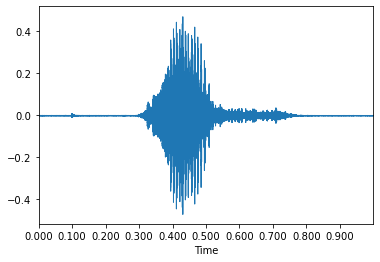

In [3]:
# 3번 셀

# 음성 라벨
labels = ['go','happy','seven','stop','yes']

# 샘플 오디오 파일 읽기
path = os.path.join(MY_PATH, 'SKL-yes.wav')
sound, rate = librosa.load(path)
print('오디오 데이터 원본 :', sound)
print('오디오 데이터 숫자 개수 :', len(sound)) # 22050HZ = 22.05KHz (CD 음질의 반)
print('sampling rate:',rate)

# 오디오 데이터의 시각화
librosa.display.waveplot(sound,rate)
plt.show()

In [4]:
# 4번 셀

# 오디오 다운 샘플링
def read_wave():
    print('<resampling 시작>')
    begin = time()
    
    # tqdm 함수로 진행 상황 출력
    for label in tqdm(labels):
        path = MY_PATH + '/' + label
        # print(path)
        waves = [f for f in os.listdir(path)]
        # print(waves[:5])
        
        for wav in waves:
            full = MY_PATH + '/' + label + '/' + wav
            # print(full)
            sound, rate = librosa.load(full)
            # print(sound)
            # print(rate)
            
            # 8KHz로 다운 샘플링
            # 22,050개의 숫자를 8,000개로 줄이는 과정
            # librosa의 resample 함수는 반드시 성공의 보장이 없음
            new = librosa.resample(sound,
                                    orig_sr = rate,
                                    target_sr = MY_RATE)
            # print(new)
            # print(len(new))
            
            # 다운 샘플링이 성공적으로 8KHz로 된 것만 저장
            if (len(new) == 8000):
                all_wave.append(new)
                all_label.append(label)
            # else:
            #     print('실패:',len(new))
            
    end = time()
    print('총 다운 샘플링 시간:',end-begin)
    print('정상 다운 샘플링 처리된 데이터 수:',len(all_wave))



In [5]:
# 5번 셀

def do_label():
    global all_label, all_wave
# 라벨 처리 (sklearn)  // sklearn 토큰화는 0부터 , keras 토큰화는 1부터 시작함
    # print('-토큰 처리 전 라벨 데이터-\n',all_label)
    encoder = LabelEncoder()
    all_label = encoder.fit_transform(all_label)
    # print('-토큰 처리 후 라벨 데이터-\n',all_label)

    # 원핫 인코딩
    all_label = to_categorical(all_label,5)
    # print('원핫 인코딩 처리 후 라벨 데이터-\n',all_label)

    # numpy 전환
    # print('all_label type :',type(all_label))
    # print('all_label type :',type(all_wave))
    all_wave = np.array(all_wave)
    
    # 모양 데이터에서 -1 : 'keras가 알아서 계산하라'
    # print('all_wave shape (reshape 전) :',all_wave.shape)
    all_wave = all_wave.reshape(-1, 8000, 1)
    # print('all_wave shape (reshape 후) :',all_wave.shape)
    

In [6]:
# 6번 셀

# 데이터 처리 control tower
path = os.path.join(MY_PATH,'audio.npy')

if DATA_MODE:
    read_wave()
    do_label()
    
    with open(path,'wb') as file:
        np.save(file,all_wave)
        np.save(file,all_label)
    
    print('데이터 처리 및 저장 완료')
else:
    with open(path,'rb') as file:
        all_wave = np.load(file)
        all_label = np.load(file)
    print('데이터 파일 읽기 완료 완료')
        

데이터 파일 읽기 완료 완료


In [7]:
# 7번 셀

# 데이터 4분할
X_train, X_test, Y_train, Y_test = train_test_split(all_wave,
                                                    all_label,
                                                    train_size=MY_SPLIT,
                                                    shuffle = True)
# 데이터 모양
print('X_train 모양 :', X_train.shape)
print('Y_train 모양 :', Y_train.shape)
print('X_test 모양  :', X_test.shape)
print('Y_test 모양  :', Y_test.shape)


X_train 모양 : (711, 8000, 1)
Y_train 모양 : (711, 5)
X_test 모양  : (178, 8000, 1)
Y_test 모양  : (178, 5)


In [9]:
# 8번 셀

# 음성 인식기 구현
# 입력층
my_input = Input(shape=(MY_RATE,1))

# 2번 그룹
x = BatchNormalization()(my_input)
x = Conv1D(filters=8,
            kernel_size=13,
            activation='relu')(x)
x = MaxPool1D(pool_size=3)(x)
x = Dropout(MY_DROP)(x)

# 3번 그룹
x = Conv1D(filters=16,
            kernel_size=11,
            activation='relu')(x)
x = MaxPool1D(pool_size=3)(x)
x = Dropout(MY_DROP)(x)


# 4번 그룹
x = Conv1D(filters=32,
            kernel_size=9,
            activation='relu')(x)
x = MaxPool1D(pool_size=3)(x)
x = Dropout(MY_DROP)(x)
x = BatchNormalization()(x)

# 5번 그룹
x = Bidirectional(GRU(units=MY_HIDDEN,
                        return_sequences=True),
                    merge_mode = 'sum')(x)

x = Bidirectional(GRU(units=MY_HIDDEN,
                        return_sequences=True),
                    merge_mode = 'sum')(x)

x = Bidirectional(GRU(units=MY_HIDDEN,
                        return_sequences=False),
                    merge_mode = 'sum')(x)

# 6번 그룹
x = BatchNormalization()(x)
x = Dense(units=256,
            activation='relu')(x)
x = Dense(units=5,
            activation='softmax')(x)

# 인공 신경망 요약
model = Model(inputs=my_input,
                outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 batch_normalization_3 (Batc  (None, 8000, 1)          4         
 hNormalization)                                                 
                                                                 
 conv1d_3 (Conv1D)           (None, 7988, 8)           112       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 2662, 8)          0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 2662, 8)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 2652, 16)          1424  

In [10]:
# 9번 셀

# 음성 인식기 학습
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['acc'])
path = MY_PATH + '/audio.h5'

if TRAIN_MODE:
    begin = time()
    print('학습 시작')
    
    model.fit(X_train,
                Y_train,
                epochs=MY_EPOCH,
                batch_size = MY_BATCH,
                verbose=1)
    
    end = time()
    print('총 학습 시간:',end - begin)
    model.save_weight(path)
else:
    model.load_weight(path)

학습 시작
Epoch 1/20
6/6 [==============================] - 66s 9s/step - loss: 1.7651 - acc: 0.2152
Epoch 2/20
6/6 [==============================] - 119s 20s/step - loss: 1.6581 - acc: 0.2293
Epoch 3/20
6/6 [==============================] - 112s 18s/step - loss: 1.6327 - acc: 0.2180
Epoch 4/20
6/6 [==============================] - 108s 17s/step - loss: 1.6104 - acc: 0.2588
Epoch 5/20
6/6 [==============================] - 141s 23s/step - loss: 1.5943 - acc: 0.2574
Epoch 6/20
2/6 [=========>....................] - ETA: 44s - loss: 1.5601 - acc: 0.2734 

KeyboardInterrupt: 

In [ ]:
# 10번 셀

# 음성 인식기 평가
score = model.evaluate(X_test,
                        Y_test)

print('최종 정확도:', score[1])

In [15]:
# 11번 셀

path = MY_PATH + '/SKL-yes.wav'
sound, rate = librosa.load(path)
print(rate)

# 8KHz로 다운 샘플링
sound = librosa.resample(sound,
                orig_sr=rate,
                target_sr=MY_RATE)

print('내 음성 다운 샘플리 결과 :',len(sound))

# 모양 정리
# 배치 정보 추가 : (1, 8000, 1)
print(type(sound))
print(sound.shape)
sound = sound.reshape(1,MY_RATE,1)

# 음성 인식기 예측
pred = model.predict(sound)
print('내 음성 예측 결과 :',labels[pred.argmax()])

22050
내 음성 다운 샘플리 결과 : 8000
<class 'numpy.ndarray'>
(8000,)


NameError: name 'moedel' is not defined